In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Get the relative path of the root path of the project, i.e. "projet_cassioppee"
import os
NOTEBOOK_DIR = os.getcwd()
ROOT = os.path.dirname(NOTEBOOK_DIR)
LIB_PATH = os.path.join(ROOT, 'libraries')

# next, add the location of the libraries:
import sys
sys.path.append(LIB_PATH)

In [3]:
import os
import time
#import sys
import tensorflow as tf
sys.path.append(os.getcwd()) #folder with code
import pandas as pd
import cv2
from skimage.io import imread, imsave

from fonction_compteur_segmentation import Hough_by_thres, recon_image, test_region, detect_para
from fonction_compteur_datagenerator import decoupe_mask, sauvegarde_imagette
from fonction_compteur_affiche import affiche,draw_ellipse_perso
from fonction_compteur import ouvrir, complet_cells
import numpy as np
import matplotlib.pyplot as plt

from skimage.filters    import  rank
from skimage.morphology import disk,black_tophat
from skimage.measure    import regionprops
from skimage.io         import imsave

In [45]:
travel = os.path.join(ROOT, 'data/inputs')
travel_output_image = os.path.join(ROOT, 'data/save_cell_slimane/')
travel_output_dataset = os.path.join(ROOT, 'data/save_cell_slimane/out/')
#travel="/content/drive/MyDrive/Stage_colab_shared/BDD_malaria_original/MAlDetect_CAT01-4/G" # travel picture input 
#travel_output_image="/content/drive/MyDrive/Stage_colab_shared/data/save_cell_slimane/" # travel output image 
#travel_output_dataset="/content/drive/MyDrive/Stage_colab_shared/data/save_cell_slimane/out/" # travel output dataset


label=True

/Users/roberthajjar/Documents/projet_cassioppee/data/inputs
9994A323901


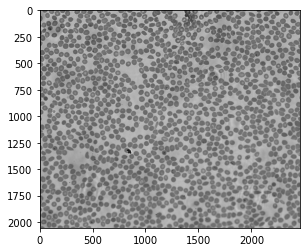

In [41]:
images=[]
file=os.listdir(travel)
names =[]

for i in file:
    if i not in ['labeled', 'examples', '.DS_Store']:
        images.append(os.path.join(travel, i))
        names.append(i)

#choice your image.
image=images[3]
name = names[3].split(".")[0]
# print(image)
# print(len(images))
raw_select = 0
#if is a raw image choose the first
image, titles, travels=ouvrir(image)
print(travel)
raw_imgs = image
if image.shape[0]==35:
    image=image[0,:,:]

#normalise image
if image.dtype!='uint8':
    img_cr=(image -image.min())/(image.max()-image.min())
    image=img_cr*255
    del(img_cr)
    image=np.array(image, dtype='uint8')


titles = titles.split( )[1] 

print(titles)
  
#plot image
plt.figure()
plt.imshow(image, cmap='gray')

# print(travel_output_dataset)


In [42]:
print(len(images))

30


In [43]:
#%%
#parameters
save=True
verbose='all'
cells_mean=60
segment='otsu canny'
close=True
boxes=['ellipse','blue']
temps=True
hough='circular cv2 skimage'



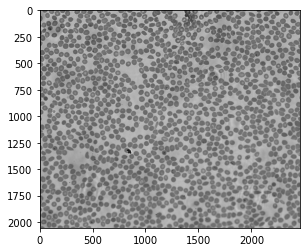

In [44]:
#%%
#begining 
debut=time.time()
origine=image.copy()
plt.figure()
plt.imshow(image,cmap='gray')


In [11]:
def extract_imagette(image, labeled,raw, coords_para, coords_distrac,cells_mean=60, size1=71, size2=71, 
                     travel_output=os.getcwd()+"_output/", tophat=False, zoro=False,mask=False):
    debut=time.time()
    #existence of folder
    if not os.path.exists(travel_output):
      os.makedirs(travel_output)
      #%mkdir -p travel_output
      #tf.compat.v1.gfile.MkDir(travel_output)
    #existence of folder tophat
    if tophat:
        travel_tophat=travel_output[:-1]+'_tophat/'
        if not os.path.exists(travel_tophat):
           os.mkdir(travel_tophat)
       
    #tranforme coords_para
   
    if coords_para is False:
        pass
    else:
         if type(coords_para)==np.ndarray:
            pass
         else:
            if 2 in coords_para.shape and len(coords_para.shape)==2:
                if coords_para.shape[0]==2:
                    coords_para=coords_para.T
                    print('coords_para.shape', coords_para.shape)
            else:
                print("coords_para n'est pas à la bonne taille\ncoords_para shape=",coords_para.shape)
                return None
         list_para=list(coords_para)
    if coords_distrac is False:
        list_distrac=[]
        pass
    else:
        list_distrac =list(coords_distrac)
    
    #tophat image
    if tophat:
        black_para=black_tophat(zoro, selem=disk(5))
        black_para[black_para.mask]=0
    
    for region in regionprops(labeled):
        infected=False
        distrac=False
        taille=image[region.bbox[0]:region.bbox[2],region.bbox[1]:region.bbox[3]].shape
        
        dx0 = region.bbox[0]
        dx1 = region.bbox[2]
        dy0 = region.bbox[1]
        dy1 = region.bbox[3]
        
        if(taille[0]%2!=0):
          dx1=dx1+1
        if(taille[1]%2!=0):
          dy1=dy1+1

        taille=image[dx0:dx1,dy0:dy1].shape

        if taille[0]>size1 or taille[1]>size2:
            # print("\n taille[0], [1]=",taille[0],",",taille[1])
            # print("\n size1", size1)
            z = 0
            #print('problème de taille')
        else:
          image_sortie=np.zeros([size1,size2], dtype='uint8')
          image_mask = np.zeros([size1,size2], dtype='uint8')
          image_mask_one = np.ones([size1,size2], dtype='uint8')
          image_tophat=np.zeros_like(image_sortie)
          if tophat:
              image_tophat=np.zeros_like(image_sortie)
          if region.equivalent_diameter>cells_mean*2/3:
              xc,yc=region.centroid
              x=int(xc-region.bbox[0])
              y=int(yc-region.bbox[1])
              center1=int(size1/2)
              center2=int(size2/2)
              begin_x=center1-x
              begin_y=center2-y
              coords = region.coords
              #test de depassement
              if np.max(coords[:,0]-region.bbox[0]+begin_x)>size1-1:
                  recalage_x=np.max(coords[:,0]-region.bbox[0]+begin_x)-size1+1
                  begin_x=begin_x-recalage_x
              if np.max(coords[:,1]-region.bbox[1]+begin_y)>size2-1:
                  recalage_y=np.max(coords[:,1]-region.bbox[1]+begin_y)-size2+1
                  begin_y=begin_y-recalage_y
              
              diffx1 = diffx2 = int((size1 - taille[0] )/2)
              diffy1 = diffy2 = int((size2 - taille[1] )/2)

              maxx,maxy = image.shape
              
              if(dx0-diffx1<0):
                diffx2 = diffx2 + (dx0-diffx1)*(-1)
                diffx1 = diffx1 - (dx0-diffx1)*(-1)
              if(dx1+diffx2 > maxx):
                diffx1 = diffx1 + (maxx- dx1-diffx2)*(-1)
                diffx2 = diffx2 - (maxx- dx1-diffx2)*(-1)
              if(dy0-diffy1<0):
                diffy2 = diffy2 + (dy0-diffy1)*(-1)
                diffy1 = diffy1 - (dy0-diffy1)*(-1)
              if(dy1+diffy2 > maxy):
                diffy1 = diffy1 + (maxy- dy1-diffy2)*(-1)
                diffy2 = diffy2 - (maxy- dy1-diffy2)*(-1)
                
              #imagette image
              # image_sortie[coords[:,0]-region.bbox[0]+begin_x, coords[:,1]-region.bbox[1]+begin_y]=\
              # image[coords[:,0],coords[:,1]]
              if (mask!=True):
                image_sortie[center1-int(size1/2):center1+int(size1/2), center2-int(size2/2):center2+int(size2/2)]=\
                image[dx0-diffx1:dx1+diffx2,dy0-diffy1:dy1+diffy2]
              else:
                image_sortie[coords[:,0]-region.bbox[0]+diffx1, coords[:,1]-region.bbox[1]+diffy1]=\
                labeled[coords[:,0],coords[:,1]]
            
              #imagette tophat
              if tophat:
                  image_tophat[coords[:,0]-region.bbox[0]+begin_x, coords[:,1]-region.bbox[1]+begin_y]=\
              black_para[coords[:,0],coords[:,1]]
              
#               title=str(region.label)+'_'+str(int(round(xc)))+'x'+str(int(round(yc)))+'.png'
              #travel_output_new = travel_output + str(region.label) + "/"
              if (mask!=True):
                title=str(raw)+'.png'
              else:
                title='mask'+'.png'
              if coords_para is False:
                  pass
              else:
                  if len(list_para)>0:
                      if len(list_para[0])==0:
                          pass
                      else:
                          for i in range(len(list_para)-1,-1,-1):
                              if list_para[i][0] in coords[:,0]:
                                  indice=np.where(coords[:,0]==list_para[i][0])[0]
                                  resultat=np.where(coords[indice,1]==list_para[i][1])[0]
                                  if len(resultat)!=0:
                                      place=indice[resultat][0]
                                      if len(resultat)==1:               
                              #        print(i,"est dans la matrice 2 en",place, "mat2["+str(place)+",:]=",matrice2[place])
                                          list_para.pop(i)
                                          infected=True
                                      else :
                                          print("problem a coords parasite is more than 1 time in a cells")
                                          print("coords = ",place)
#                        print(valeur,"en matrice 2 à",place)
              if infected:
                  #pas de distracteur
                  pass
              else:
                  if coords_distrac is False:
                      pass
                  else:
                      for i in range(len(list_distrac)-1,-1,-1):
                          if list_distrac[i][0] in coords[:,0]:
                              indice=np.where(coords[:,0]==list_distrac[i][0])[0]
                              resultat=np.where(coords[indice,1]==list_distrac[i][1])[0]
                              if len(resultat)!=0:
                                  place=indice[resultat][0]
                                  if len(resultat)==1:               
                          #        print(i,"est dans la matrice 2 en",place, "mat2["+str(place)+",:]=",matrice2[place])
                                      list_distrac.pop(i)
                                      distrac=True
                                  else :
                                      print("problem a coords parasite is more than 1 time in a cells")
                                      print("coords = ",place)
  #                        print(valeur,"en matrice 2 à",place)
              
              
              if infected:
                  travel_output_new = travel_output + 'infected_' + str(region.label) + "/" 
                  #title='infected_'+title
              else:
                  if distrac:
                    travel_output_new = travel_output + 'distrac_' + str(region.label) + "/" 
                    #title = 'distrac_'+title
                  else:
                    travel_output_new = travel_output + 'healthy_' + str(region.label) + "/" 
                    #title='healthy_'+title
    #    plt.close("all")
    #    plt.figure()
    #    plt.imshow(image_sortie)
              if not os.path.exists(travel_output_new):
                os.makedirs(travel_output_new)
              imsave(travel_output_new+title, image_sortie)
              if tophat:
                  imsave(travel_tophat+title, image_tophat, check_contrast=False)
    fin=time.time()
    #print(fin-debut)
#    print(coords_para)
    if not coords_para is False:
        if len(list_para)>0:
#            print("il reste des parasites non detecter")
            print("longueur de liste para =",len(list_para))
            return list_para
    else:
        return None

In [46]:
name

'9994A323901'

In [47]:
#%%
#extract parasite coords.
if label :
    csv_path = os.path.join(ROOT, 'data/csv/', name + ".csv")
    coords_para=pd.read_csv(csv_path, sep=';')
    #coords_para=detect_para (image,zoro, verbose=True, title='image', thres=10)
else :
    coords_para=[[],[]]

coords_para = np.array(coords_para)
print(list(coords_para))

[array([145, 476]), array([151, 962]), array([179,  97]), array([ 197, 1699]), array([ 217, 1828]), array([ 252, 1669]), array([269, 624]), array([287, 730]), array([316, 448]), array([389, 501]), array([ 421, 2041]), array([ 455, 1936]), array([ 450, 1203]), array([ 492, 1284]), array([ 508, 2109]), array([ 631, 1666]), array([ 713, 1930]), array([ 735, 1196]), array([ 827, 2075]), array([846, 441]), array([ 861, 1042]), array([912, 416]), array([ 975, 1381]), array([1241, 1542]), array([1304,  137]), array([1325,  498]), array([1335,  671]), array([1344, 1172]), array([1409,  519]), array([1440, 1809]), array([1485, 1656]), array([1519, 1252]), array([1583, 1542]), array([1641,  610]), array([1708,  751]), array([1732,  376]), array([1743, 2210]), array([1750, 1351]), array([1756,  399]), array([1762,   74]), array([1768, 1808]), array([1789, 1931]), array([1850, 1676]), array([1901,   94]), array([1922, 1110]), array([1964, 1570]), array([1984, 1014]), array([1996,  488]), array([20

In [48]:
print(travel_output_dataset)

/Users/roberthajjar/Documents/projet_cassioppee/data/save_cell_slimane/out/


In [49]:
titles

'9994A323901'

In [50]:
labeled_path = os.path.join (ROOT, 'data/labeled/', titles + ' labeling.png')
labeled=imread(labeled_path)

classe=regionprops(labeled)
print('nb cells detected = ',len(classe))

for i in range(0,35):
  print(i)
  image = raw_imgs[i,:,:]
  #normalise image
  if image.dtype!='uint8':
      img_cr=(image -image.min())/(image.max()-image.min())
      image=img_cr*255
      del(img_cr)
      image=np.array(image, dtype='uint8')
  travel_output_modi = travel_output_dataset + titles+'/'
  extract_imagette(image, labeled, coords_para=coords_para, coords_distrac=False,raw=i,cells_mean=60, size1=84, size2=84,  travel_output=travel_output_modi,mask=False)


# image = raw_imgs[0,:,:]
# #normalise image
# if image.dtype!='uint8':
#     img_cr=(image -image.min())/(image.max()-image.min())
#     image=img_cr*255
#     del(img_cr)
#     image=np.array(image, dtype='uint8')
# travel_output_modi = travel_output_dataset + titles+'/'
# extract_imagette(image, labeled, coords_para=coords_para, coords_distrac=False,raw=0,cells_mean=60, size1=84, size2=84,  travel_output=travel_output_modi,mask=True)

nb cells detected =  1175
0
longueur de liste para = 4
1
longueur de liste para = 4
2
longueur de liste para = 4
3
longueur de liste para = 4
4
longueur de liste para = 4
5
longueur de liste para = 4
6
longueur de liste para = 4
7
longueur de liste para = 4
8
longueur de liste para = 4
9
longueur de liste para = 4
10
longueur de liste para = 4
11
longueur de liste para = 4
12
longueur de liste para = 4
13
longueur de liste para = 4
14


<ipython-input-11-b5785a0fd050>:186: UserWarning: /Users/roberthajjar/Documents/projet_cassioppee/data/save_cell_slimane/out/9994A323901/healthy_1205/14.png is a low contrast image
  imsave(travel_output_new+title, image_sortie)
<ipython-input-11-b5785a0fd050>:186: UserWarning: /Users/roberthajjar/Documents/projet_cassioppee/data/save_cell_slimane/out/9994A323901/healthy_1207/14.png is a low contrast image
  imsave(travel_output_new+title, image_sortie)
<ipython-input-11-b5785a0fd050>:186: UserWarning: /Users/roberthajjar/Documents/projet_cassioppee/data/save_cell_slimane/out/9994A323901/healthy_3525/14.png is a low contrast image
  imsave(travel_output_new+title, image_sortie)
<ipython-input-11-b5785a0fd050>:186: UserWarning: /Users/roberthajjar/Documents/projet_cassioppee/data/save_cell_slimane/out/9994A323901/healthy_4211/14.png is a low contrast image
  imsave(travel_output_new+title, image_sortie)
<ipython-input-11-b5785a0fd050>:186: UserWarning: /Users/roberthajjar/Documents/proj

longueur de liste para = 4
15


<ipython-input-11-b5785a0fd050>:186: UserWarning: /Users/roberthajjar/Documents/projet_cassioppee/data/save_cell_slimane/out/9994A323901/healthy_5133/15.png is a low contrast image
  imsave(travel_output_new+title, image_sortie)


longueur de liste para = 4
16
longueur de liste para = 4
17
longueur de liste para = 4
18
longueur de liste para = 4
19
longueur de liste para = 4
20
longueur de liste para = 4
21
longueur de liste para = 4
22
longueur de liste para = 4
23
longueur de liste para = 4
24
longueur de liste para = 4
25
longueur de liste para = 4
26
longueur de liste para = 4
27
longueur de liste para = 4
28
longueur de liste para = 4
29
longueur de liste para = 4
30
longueur de liste para = 4
31
longueur de liste para = 4
32
longueur de liste para = 4
33
longueur de liste para = 4
34
longueur de liste para = 4
